In [28]:
import torchvision.models as models
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# from umap import UMAP
from sklearn.decomposition import KernelPCA
import urllib
import warnings
from torchvision.transforms import ToTensor
import os
import random
warnings.filterwarnings("ignore", category=UserWarning)

ImportError: cannot import name 'UMAP' from 'umap' (c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\__init__.py)

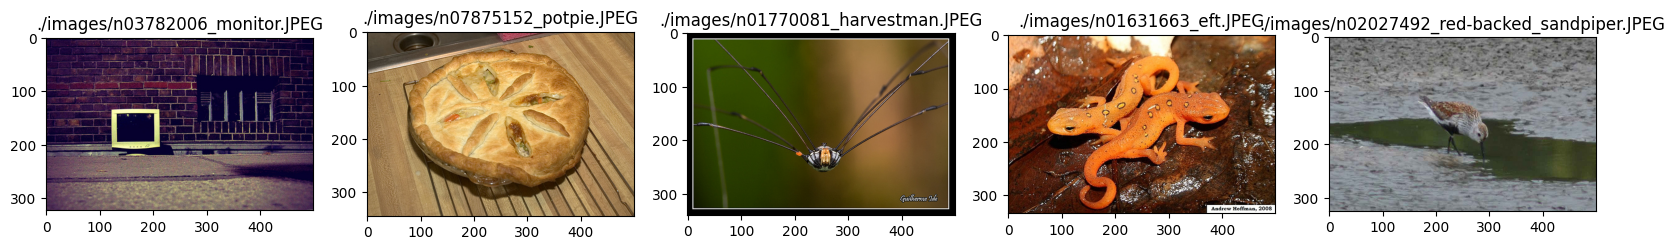

In [21]:
path = './images/'
image_files = [os.path.join(path, f) for f in os.listdir(path)]

num_images_to_load = 5
random_images = random.sample(image_files, num_images_to_load)

loaded_images = []
fig, axs = plt.subplots(nrows=1, ncols=num_images_to_load, figsize=(20, 20))
for i, image_path in enumerate(random_images):
    img = Image.open(image_path)
    loaded_images.append(image_path)
    axs[i].imshow(img)
    axs[i].set_title(image_path)
plt.show()

In [29]:
class ClassActivationMaps():
  def __init__(self, model_name):
    self.model_name = model_name
    self.model = self.init_model(model_name)
    self.features = None
    self.h_w = None
    self.n_features = None
    self.methods = {}

  def init_model(self, model_name):
    if self.model_name == 'vgg16':
      return models.vgg16(pretrained=True)
    else:
      return models.resnet50(pretrained=True)

  def hook(self,module, input, output):
    self.features = output
  
  def normalize_image(self,img_path):
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path)
    img_tensor = preprocess(img)
    return img_tensor.unsqueeze_(0)

  def normalize_cam(self, cam):
    return (cam - cam.min())/(cam.max() - cam.min())

  def makeFeatures(self, image_path ):
    self.img_tensor = self.normalize_image(image_path)

    if self.model_name == 'resnet50':
      self.model.layer4[-1].conv3.register_forward_hook(self.hook)
    else:
      self.model.features[-3].register_forward_hook(self.hook)

    self.outputs = self.model(self.img_tensor)
    self.n_features = self.features.shape[1]
    self.h_w = self.features.shape[2]


  def getPrediction(self):
    _, predicted = torch.max(self.outputs.data, 1)
    url = "https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt"
    class_file_name = "imagenet_classes.txt"
    urllib.request.urlretrieve(url, class_file_name)

    with open(class_file_name) as f:
        classes = [line.strip() for line in f.readlines()]

    print("Predicted as",classes[predicted[0]])
    return predicted


  def make_cam(self, image_path):
    self.makeFeatures(image_path)
    self.predicted = self.getPrediction()
    feature_maps_flat = self.features.reshape(self.n_features, self.h_w * self.h_w)
    prob = torch.softmax(self.outputs, dim=1)[0, self.predicted]
    grads = torch.autograd.grad(outputs=prob, inputs=self.features, retain_graph=True, allow_unused=True)[0]
    self.pooled_grads = torch.mean(grads, dim=(2, 3), keepdim=True)
    # print("grads make cam shape:", grads.shape)
    self.grads = grads.view((self.n_features,-1))
    self.pca , self.pca_grad = self._Kernel_PCA(feature_maps_flat, kernel='linear')
    self.k_pca, self.k_pca_grad = self._Kernel_PCA(feature_maps_flat, kernel='rbf')
    self.pca_k_vect  = self._PCA_k_Vector(feature_maps_flat, self.n_features,  grad_kernel='rbf')
    self.ei_cam = self.eigen_cam(feature_maps_flat)
    self.gr_cam = self.grad_cam(feature_maps_flat)
    self.t_sne_cam = self._T_SNE(feature_maps_flat)
    # self.umap_vec = self._UMAP(feature_maps_flat)
    # self.kernel_pca_k_vect  = self._kernel_pca_k_vector_nograd(feature_maps_flat, self.h_w*self.h_w)
    self.print_images()

  # def _PCA(self,feature_maps_flat):
  #   pca = PCA(n_components=1, random_state=0) 
  #   return self.pca_nograd(feature_maps_flat, pca), self.pca_grad(feature_maps_flat, pca)

  def _T_SNE(self,feature_maps_flat):
    t_sne = TSNE(n_components=1, learning_rate='auto',init='random', perplexity=3)
    t_sne_components = t_sne.fit_transform(feature_maps_flat.detach().numpy())
    feature_weighted_tsne = np.dot(t_sne_components.squeeze() ,feature_maps_flat.cpu().detach().numpy())
    feature_weighted_tsne = np.absolute(feature_weighted_tsne)
    feature_weighted_tsne = feature_weighted_tsne.reshape((self.h_w,self.h_w))
    feature_weighted_tsne = cv2.resize(feature_weighted_tsne, (224, 224))
    feature_weighted_tsne = self.normalize_cam(feature_weighted_tsne)
    self.methods['T-SNE'] = feature_weighted_tsne
    # cv2.imwrite('./cams/feature_weighted_tsne.jpg', feature_weighted_tsne)
    return feature_weighted_tsne 

  # ca n'a pas marche
  # def _UMAP(self,feature_maps_flat):
  #   _umap = umap.UMAP(n_components=1)
  #   _umap_components = _umap.fit_transform(feature_maps_flat.detach().numpy())
  #   feature_weighted_tsne = np.dot(_umap_components.squeeze() ,feature_maps_flat.cpu().detach().numpy())
  #   feature_weighted_tsne = np.absolute(feature_weighted_tsne)
  #   feature_weighted_tsne = feature_weighted_tsne.reshape((self.h_w,self.h_w))
  #   feature_weighted_tsne = cv2.resize(feature_weighted_tsne, (224, 224))
  #   feature_weighted_tsne = self.normalize_cam(feature_weighted_tsne)
  #   self.methods['UMAP'] = feature_weighted_tsne
  #   # cv2.imwrite('./cams/feature_weighted_tsne.jpg', feature_weighted_tsne)
  #   return feature_weighted_tsne 

  def _PCA_k_Vector(self, feature_maps_flat, k, grad_kernel):
    pca =  KernelPCA(n_components=k, kernel ='linear', random_state=0)
    kernel_pca =  KernelPCA(n_components=k, kernel =grad_kernel, random_state=0)
    pca_k_vect = self._pca_k_vector_nograd(feature_maps_flat, pca)
    # k_pca_k_vect = self._kpca_k_vector_grad(feature_maps_flat, kernel_pca)
    self.methods['pca k vector'] = pca_k_vect
    # self.methods['kernel_pca k vector'] = k_pca_k_vect
    # return pca_k_vect, k_pca_k_vect
    return pca_k_vect

  def _Kernel_PCA(self,feature_maps_flat, kernel):
    kernel_pca = KernelPCA(n_components=1, kernel =kernel, random_state=0)
    kernel_pca_n_grad = self.k_pcanograd(feature_maps_flat,kernel_pca)
    kernel_pca_grad = self.k_pcagrad(feature_maps_flat,kernel_pca)
    if(kernel == 'linear'):
      # self.methods.append(['pca', 'grad pca'])
      self.methods['pca'] = kernel_pca_n_grad
      self.methods['grad pca'] = kernel_pca_grad
    else:
      # self.methods.append(['kernel_pca', 'grad kernel_pca'])
      self.methods['kernel_pca'] = kernel_pca_n_grad
      self.methods['grad kernel_pca'] = kernel_pca_grad

    return kernel_pca_n_grad, kernel_pca_grad
  
  def k_pcanograd(self, feature_maps_flat, kernel_pca):
    kernel_pca_components = kernel_pca.fit_transform(feature_maps_flat.detach().numpy())
    feature_weighted_kernel = np.dot(kernel_pca_components.squeeze() ,feature_maps_flat.cpu().detach().numpy())
    feature_weighted_kernel = np.absolute(feature_weighted_kernel)
    feature_weighted_kernel = feature_weighted_kernel.reshape((self.h_w,self.h_w))
    feature_weighted_kernel = cv2.resize(feature_weighted_kernel, (224, 224))
    feature_weighted_kernel = self.normalize_cam(feature_weighted_kernel)
    # cv2.imwrite('./cams/feature_weighted_kernel.jpg', feature_weighted_kernel)
    return feature_weighted_kernel 
  
  def k_pcagrad(self, feature_maps_flat, kernel_pca):
    kernel_pca_components_grad = kernel_pca.fit_transform(self.grads.detach().numpy())
    feature_weighted_kernel_grad = np.dot(kernel_pca_components_grad.squeeze() ,feature_maps_flat.cpu().detach().numpy())
    feature_weighted_kernel_grad = np.absolute(feature_weighted_kernel_grad)
    feature_weighted_kernel_grad = feature_weighted_kernel_grad.reshape((self.h_w,self.h_w))
    feature_weighted_kernel_grad = cv2.resize(feature_weighted_kernel_grad, (224, 224))
    feature_weighted_kernel_grad = self.normalize_cam(feature_weighted_kernel_grad)
    # cv2.imwrite('./cams/feature_weighted_kernel_grad.jpg', feature_weighted_kernel_grad)
    return feature_weighted_kernel_grad 
 

  def eigen_cam(self,feature_maps_flat):
    features = feature_maps_flat.T
    U, S, V = torch.svd(features)
    eigen_cam = features @ V[:,0]
    eigen_cam = eigen_cam.reshape((self.h_w, self.h_w))
    eigen_cam = np.absolute(eigen_cam.detach().numpy())
    eigen_cam = cv2.resize(eigen_cam, (224, 224))
    eigen_cam = self.normalize_cam(eigen_cam)
    self.methods['Eigen-cam'] = eigen_cam
    return eigen_cam

  def grad_cam(self, feature_maps_flat):
    weighted_features = self.features * self.pooled_grads
    cam = torch.sum(weighted_features, dim=1, keepdim=True)
    # cam = F.relu(cam)
    cam = cam.abs()
    cam = cam.detach().numpy()[0,0,:,:]
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min())/(cam.max() - cam.min())
    cam = self.normalize_cam(cam)
    self.methods['grad-cam'] = cam
    return cam 

  def _pca_k_vector_nograd(self, feature_maps_flat, pca):
    principal_components = pca.fit_transform(feature_maps_flat.detach().numpy())
    eigen_values = np.array([v/np.max(pca.eigenvalues_) for v in pca.eigenvalues_] )
    # print(eigen_values.shape)
    weighted_variance_vector = np.dot(principal_components.T, feature_maps_flat.cpu().detach().numpy())
    weighted_variance_vector = np.expand_dims(eigen_values, axis=-1) * weighted_variance_vector 
    # print(weighted_variance_vector.shape)
    cam = np.sum(weighted_variance_vector, axis=0)
    cam = cam.reshape((self.h_w, self.h_w))
    cam = cv2.resize(cam, (224, 224))
    cam = np.absolute(cam)
    cam = self.normalize_cam(cam)
    return cam

  # ca n'a pas marche
  # def _kpca_k_vector_grad(self, feature_maps_flat, kernel_pca):
  #     pos_grads = np.absolute(self.grads.detach().numpy())
  #     principal_components = kernel_pca.fit_transform(pos_grads)
  #     # principal_components = np.absolute(principal_components)
  #     eigen_values = np.array([v/np.max(kernel_pca.eigenvalues_) for v in kernel_pca.eigenvalues_] )
  #     # print(eigen_values.shape)
  #     weighted_variance_vector = np.dot(principal_components.T, feature_maps_flat.cpu().detach().numpy())
  #     weighted_variance_vector = np.expand_dims(eigen_values, axis=-1) * weighted_variance_vector 
  #     # print(weighted_variance_vector.shape)
  #     cam = np.sum(weighted_variance_vector, axis=0)
  #     cam = cam.reshape((self.h_w, self.h_w))
  #     cam = cv2.resize(cam, (224, 224))
  #     cam = np.absolute(cam)
  #     cam = self.normalize_cam(cam)
  #     return cam
 

  def print_images(self):
    # fig = plt.figure(figsize=(20, 20))
    # axs = fig.subplots(nrows=1, ncols=7)

    fig, axs = plt.subplots(nrows=1, ncols=len(self.methods), figsize=(20, 20))
    for i, method in enumerate(self.methods.items()):
      axs[i].imshow(self.img_tensor.cpu().squeeze().permute(1,2,0).numpy())
      axs[i].imshow(method[1],alpha=0.5, cmap='jet')
      axs[i].set_title(method[0])
    plt.axis('off')
    plt.show()
    
    fig.savefig('./cams/cam.png')
    # for i, ax in enumerate(axs):
    #     fig_name = f'./cams/subplot_{i}.png'
    #     cv2.imwrite(fig_name , ax.get_figure())


Predicted as screen, CRT screen


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


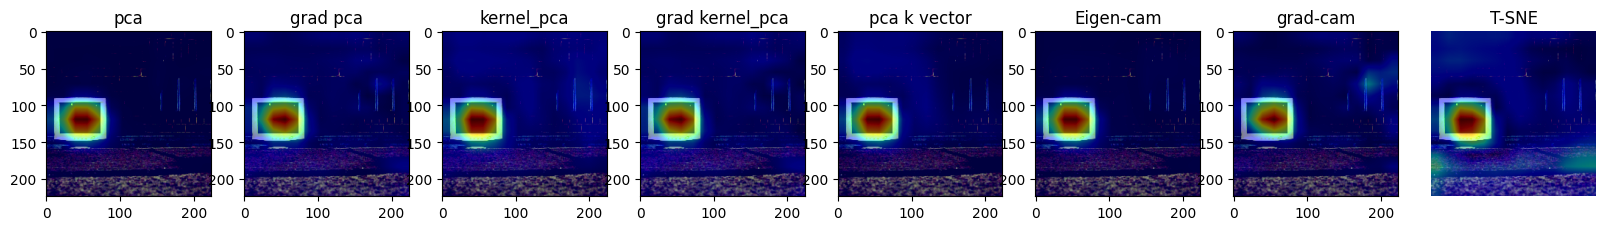

In [30]:

# image_path = './african_elephant.jpg'
image_path = loaded_images[0]

# resnet50 = ClassActivationMaps('resnet50')
# resnet50.make_cam(image_path)

vgg16 = ClassActivationMaps('vgg16')
vgg16.make_cam(image_path)


Predicted as potpie


C:\Users\user\AppData\Local\Temp\ipykernel_14616\2074007403.py:34: RuntimeWarning: invalid value encountered in divide
  return (cam - cam.min())/(cam.max() - cam.min())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB d

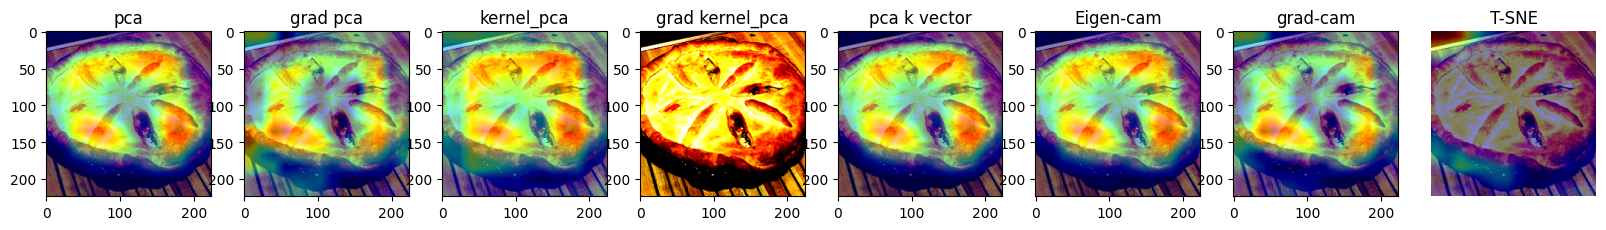

In [31]:
image_path = loaded_images[1]

# resnet50 = ClassActivationMaps('resnet50')
# resnet50.make_cam(image_path)

vgg16 = ClassActivationMaps('vgg16')
vgg16.make_cam(image_path)

Predicted as harvestman, daddy longlegs, Phalangium opilio


C:\Users\user\AppData\Local\Temp\ipykernel_14616\2074007403.py:34: RuntimeWarning: invalid value encountered in divide
  return (cam - cam.min())/(cam.max() - cam.min())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB d

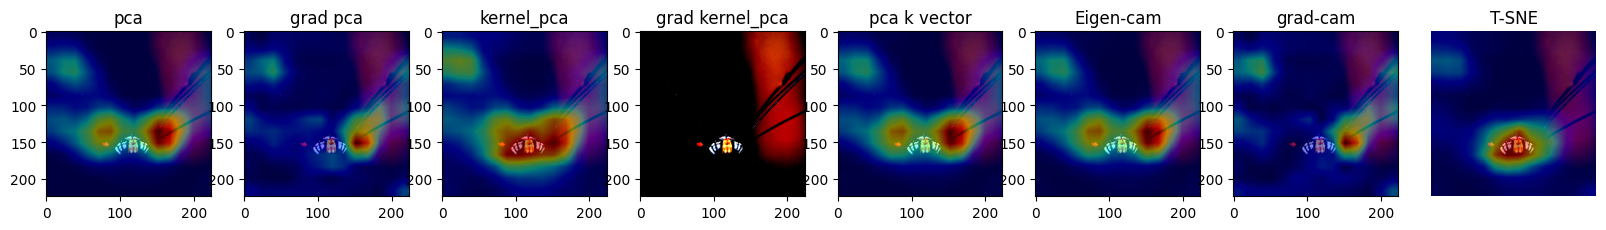

In [32]:
image_path = loaded_images[2]

# resnet50 = ClassActivationMaps('resnet50')
# resnet50.make_cam(image_path)

vgg16 = ClassActivationMaps('vgg16')
vgg16.make_cam(image_path)

Predicted as eft


C:\Users\user\AppData\Local\Temp\ipykernel_14616\2074007403.py:34: RuntimeWarning: invalid value encountered in divide
  return (cam - cam.min())/(cam.max() - cam.min())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB d

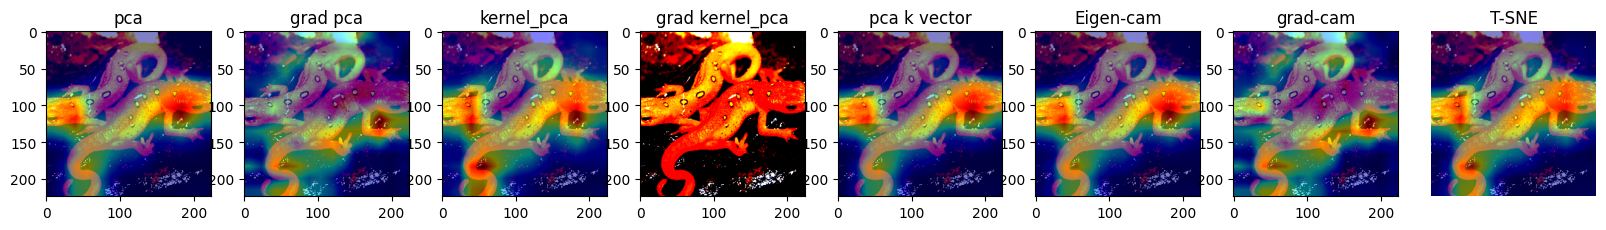

In [33]:
image_path = loaded_images[3]

# resnet50 = ClassActivationMaps('resnet50')
# resnet50.make_cam(image_path)

vgg16 = ClassActivationMaps('vgg16')
vgg16.make_cam(image_path)

Predicted as red-backed sandpiper, dunlin, Erolia alpina


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


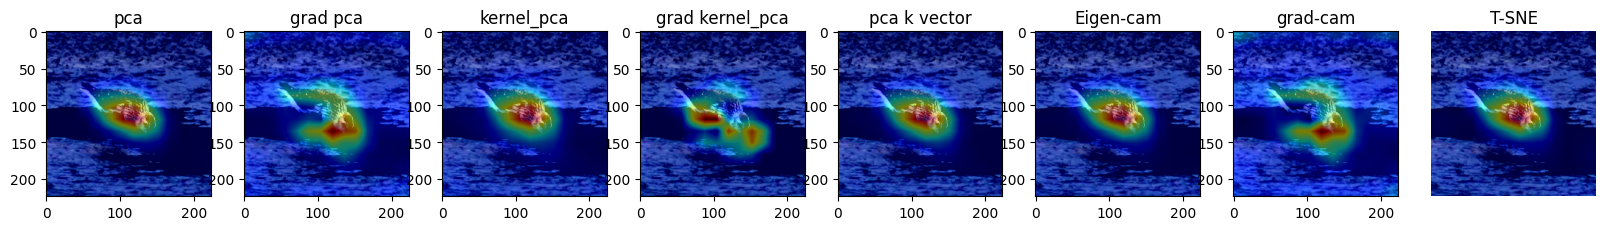

In [34]:
image_path = loaded_images[4]

# resnet50 = ClassActivationMaps('resnet50')
# resnet50.make_cam(image_path)

vgg16 = ClassActivationMaps('vgg16')
vgg16.make_cam(image_path)